## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
test_label = test[:, 0]

# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

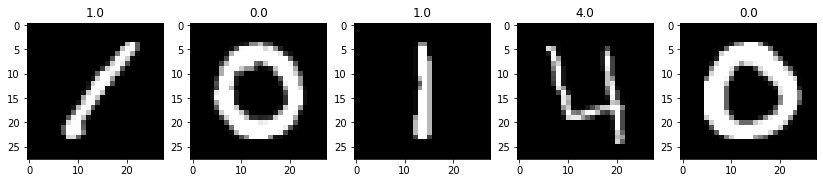

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

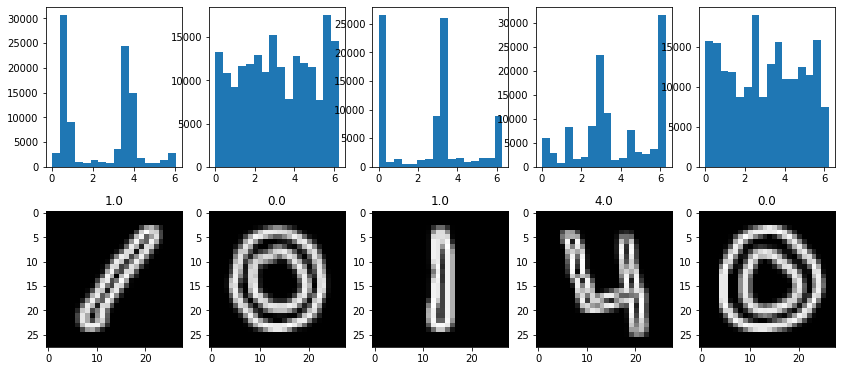

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [15]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [16]:
test_hist

array([[0.21448469, 0.15238823, 0.1476137 , ..., 0.28202574, 0.14212265,
        0.09890287],
       [0.21195734, 0.20390083, 0.18344614, ..., 0.07866052, 0.1623255 ,
        0.14064794],
       [0.14227586, 0.51313664, 0.25089185, ..., 0.0729064 , 0.08885792,
        0.07379159],
       ...,
       [0.12102448, 0.13528412, 0.3129838 , ..., 0.22503678, 0.18437524,
        0.12063432],
       [0.44308301, 0.32625034, 0.292274  , ..., 0.07670911, 0.07828175,
        0.15285636],
       [0.12231744, 0.22805679, 0.37803543, ..., 0.18860724, 0.16308817,
        0.10261609]])

## Применим Классификацию через случайный лес

In [17]:
RFC=RandomForestClassifier(n_estimators=50, max_depth=25, random_state=1)
RFC.fit(x_train, y_train)
pred_val=RFC.predict(x_val)
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.6376190476190476


In [18]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.41      0.38      0.40       816
         1.0       0.97      0.96      0.96       909
         2.0       0.46      0.45      0.45       846
         3.0       0.65      0.68      0.66       937
         4.0       0.71      0.71      0.71       839
         5.0       0.62      0.64      0.63       702
         6.0       0.49      0.46      0.48       785
         7.0       0.85      0.80      0.82       893
         8.0       0.51      0.57      0.54       835
         9.0       0.66      0.67      0.67       838

    accuracy                           0.64      8400
   macro avg       0.63      0.63      0.63      8400
weighted avg       0.64      0.64      0.64      8400



In [19]:
print(confusion_matrix(y_val, pred_val))

[[312   7  66  32  38  18 119   9 172  43]
 [  1 870   2   0  22   0   1   6   2   5]
 [ 65   0 380 132   1 107  57  18  70  16]
 [ 22   0 102 633   0  85  11   4  69  11]
 [ 18  13  11   3 593   1  83  33   8  76]
 [  6   0  95 102   1 452   5   8  31   2]
 [134   1  62  11  66   8 365  14  70  54]
 [  7   4  31   4  49  15  18 711   6  48]
 [135   0  50  46   9  41  36   5 475  38]
 [ 55   1  32  17  58   4  54  25  27 565]]


## Визуализируем предсказания

In [20]:
pred_test=RFC.predict(test_hist)

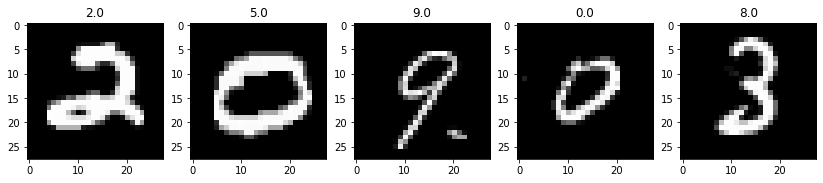

In [21]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [22]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [23]:
!head submit.txt

ImageId,Label
1,2.0
2,5.0
3,9.0
4,0.0
5,8.0
6,7.0
7,0.0
8,3.0
9,6.0


In [24]:
# Your submission scored 0.41700